# 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 2. Dataset

In [3]:
data = pd.read_csv('datasets/emotion_sentimen_dataset.csv', usecols=['text', 'Emotion'])  # Load dataset using pandas
data.head(5) # Check dataset structure using head() from pandas

,text,Emotion
0,Life is an incredible journey full of adventures!,happy
1,Every obstacle just fuels my anger more.,angry
2,"Sometimes, the silence of the room feels overw...",sad
3,I just don't feel strongly about anything today.,neutral
4,The sun shining through the leaves fills me wi...,happy


In [4]:
data.shape # Check data rows and columns

(1146, 2)

In [5]:
data = data.dropna(subset=['text', "Emotion"]) # Removing empty values from ['text', "Emotion"]
data.head()

,text,Emotion
0,Life is an incredible journey full of adventures!,happy
1,Every obstacle just fuels my anger more.,angry
2,"Sometimes, the silence of the room feels overw...",sad
3,I just don't feel strongly about anything today.,neutral
4,The sun shining through the leaves fills me wi...,happy


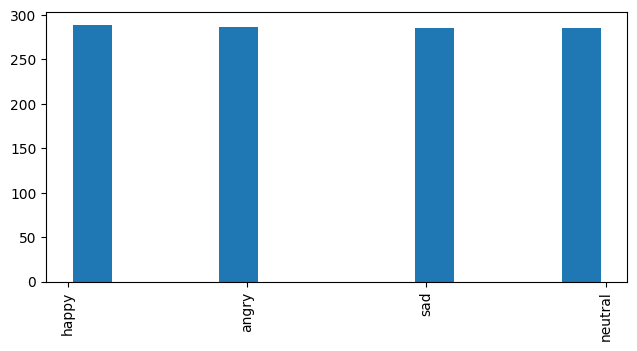

In [6]:
plt.figure(figsize=(7.5,3.5))  # Creating polot of ammount of texts for each label(Emotion)
plt.hist(data.Emotion, bins=11, rwidth=0.8)
plt.xticks(rotation=90)
plt.show()

In [7]:

train_temp, test = train_test_split(data, test_size=0.2, stratify=data['Emotion'])  # Split data to train_temp and test
train, val = train_test_split(train_temp, test_size=0.25, stratify=train_temp['Emotion'])  # Split train_temp for train data and validation data

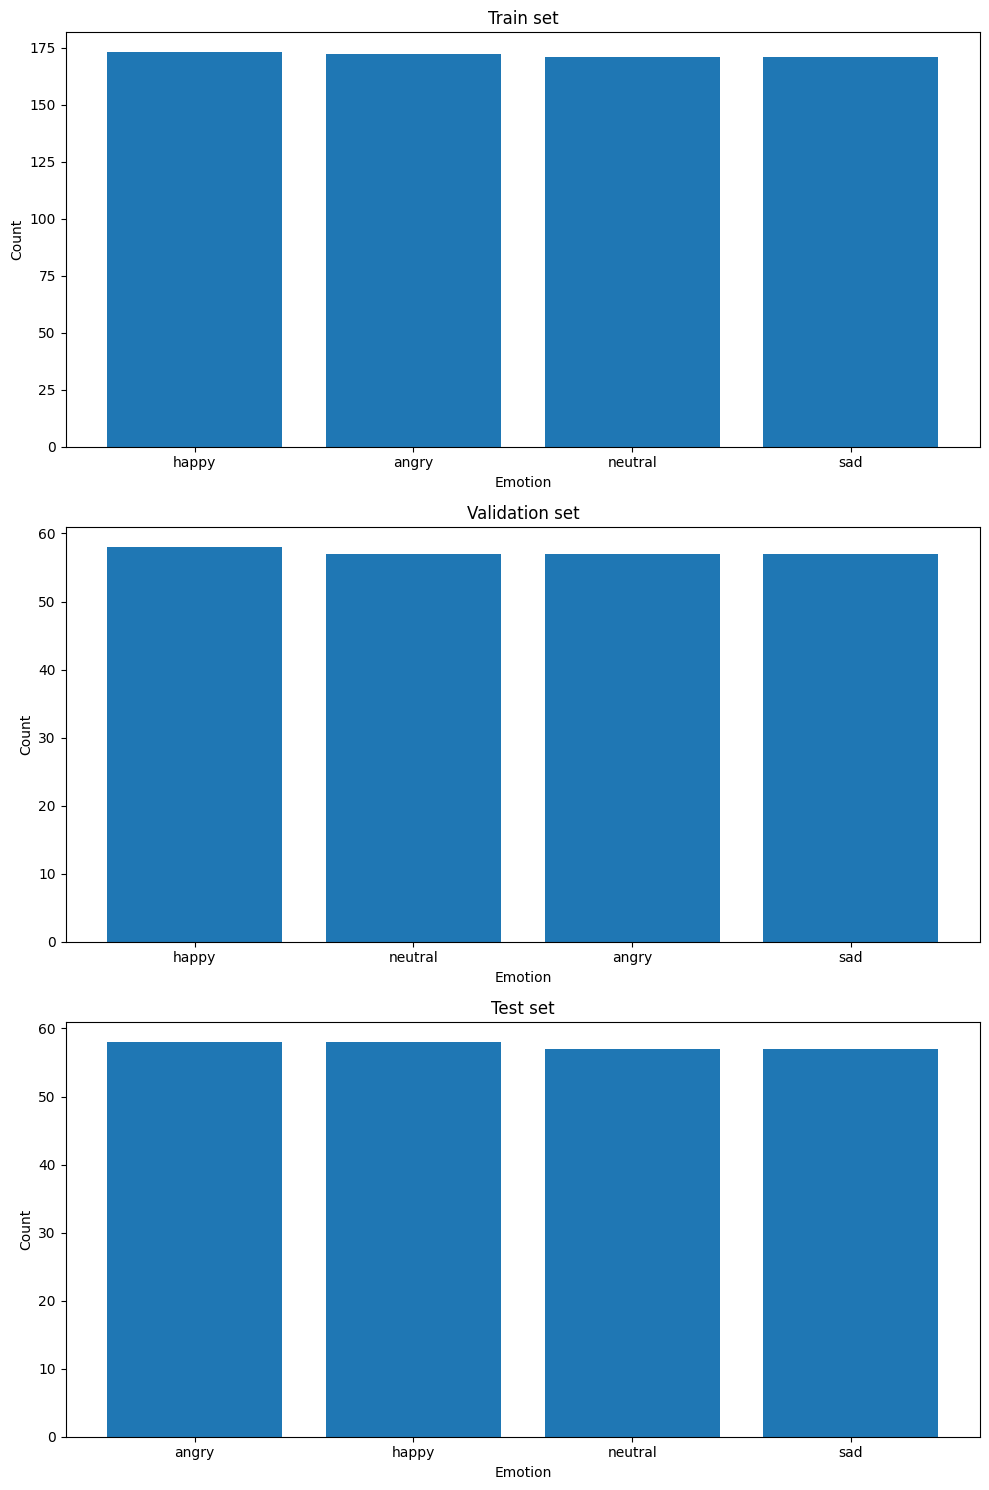

In [8]:

fig, axs = plt.subplots(3, figsize=(10, 15)) # Plot for each split dataset

axs[0].bar(train['Emotion'].value_counts().index, train['Emotion'].value_counts().values)
axs[0].set_title('Train set')

axs[1].bar(val['Emotion'].value_counts().index, val['Emotion'].value_counts().values)
axs[1].set_title('Validation set')

axs[2].bar(test['Emotion'].value_counts().index, test['Emotion'].value_counts().values)
axs[2].set_title('Test set')

for ax in axs:
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [9]:
def df_to_dataset(dataframe, num_classes, shuffle=True, batch_size=32): # Converting data from pandas DataFrame to Tensorflow Dataset
    df = dataframe.copy()
    labels = df.pop('Emotion')

    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)

    num_classes = len(np.unique(labels))

    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    df = df['text']
    ds = tf.data.Dataset.from_tensor_slices((df.values, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

In [10]:
train_data = df_to_dataset(train, num_classes=4) # Converting each dataset to Tensorflow Dataset, num_classses = 4 because we have 4 emotions['angry' 'neutral' 'happy' 'sad']
val_data = df_to_dataset(val, num_classes=4)
test_data = df_to_dataset(test, num_classes=4)

In [11]:
labels = train['Emotion'].unique() # Creating labels (4 different emotions)
print(labels)
num_classes = len(labels)


['neutral' 'happy' 'angry' 'sad']


# 3. Model

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)  # Creating encoder for model to test it on text
encoder.adapt(train_data.map(lambda text, label: text))

# Defining a sequential Keras model
model = tf.keras.Sequential([
    encoder,  # Adding TextVectorization layer to the model, which converts text into sequences of numbers
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Specifying the number of unique words in the encoder
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),  # LSTM layer with 32 units
    tf.keras.layers.Dense(32, activation='relu'),  # Dense layer with ReLU activation
    tf.keras.layers.Dropout(0.4),  # Dropout layer with 40% units dropped out
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Setting Adam optimizer with specified learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Setting loss function to categorical cross-entropy
    metrics=['accuracy']  # Adding accuracy metric for model evaluation
)



In [16]:
model.evaluate(train_data) # Model evaluation on training data

22/22 [==============================] - 4s 5ms/step - loss: 1.3874 - accuracy: 0.1412


[1.3874355554580688, 0.14119359850883484]

In [17]:
model.evaluate(val_data) # Model evaluation on validation data

8/8 [==============================] - 0s 5ms/step - loss: 1.3874 - accuracy: 0.1441


[1.387400507926941, 0.14410480856895447]

In [18]:
history = model.fit(train_data, epochs=5, validation_data=val_data) # Creating "handle" called history to get access to each training step


Epoch 1/5
22/22 [==============================] - 6s 16ms/step - loss: 1.3627 - accuracy: 0.5619 - val_loss: 1.3109 - val_accuracy: 0.8166
Epoch 2/5
22/22 [==============================] - 0s 17ms/step - loss: 1.1596 - accuracy: 0.7322 - val_loss: 0.8777 - val_accuracy: 0.7205
Epoch 3/5
22/22 [==============================] - 0s 18ms/step - loss: 0.6852 - accuracy: 0.8253 - val_loss: 0.3798 - val_accuracy: 0.9345
Epoch 4/5
22/22 [==============================] - 0s 16ms/step - loss: 0.2769 - accuracy: 0.9461 - val_loss: 0.1525 - val_accuracy: 0.9520
Epoch 5/5
22/22 [==============================] - 0s 18ms/step - loss: 0.1167 - accuracy: 0.9854 - val_loss: 0.1287 - val_accuracy: 0.9520


In [19]:
model.evaluate(test_data) # Model evaluation on test data

8/8 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9522


[0.1717681586742401, 0.9521738886833191]

In [20]:
model.save('Models/emotions3.keras') # Saving the model

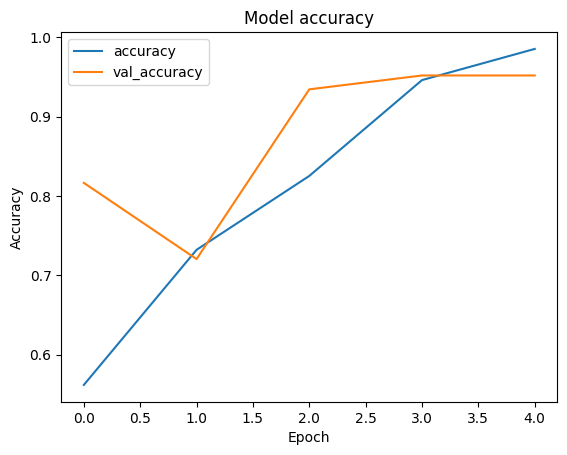

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')  # Creating plot with accuracy and validation accuracy for each Epoch
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 4. Testing

In [22]:
model = tf.keras.models.load_model('Models/emotions3.keras') # Loading the model

In [23]:
import string  # Cleaning the text

def preprocess_text(text):
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

In [27]:
def predict_label(text):  # Label pradiction from given sentence
    text = preprocess_text(text)

    text = tf.constant([text])

    prediction = model.predict(text)

    predicted_index = np.argmax(prediction[0])

    return predicted_index

test1 = labels[predict_label("I dislike your behaviour")]
test2 = labels[predict_label('I am so happy for you')]
print(test1, test2, sep = "\n")

1/1 [==============================] - 0s 27ms/step
angry
happy
